#### Import necessary libraries

In [29]:
import chess
import chess.svg
import subprocess
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display, clear_output, SVG
import random
import matplotlib.pyplot as plt
import time
import numpy as np
import GPUtil
import psutil
import torch
import chess.engine

## LC0

### Initialization of Chess Board and Widgets

In [30]:
board = chess.Board()
board_output = widgets.Output()
info_output = widgets.Output()

#### Display the last move made

In [31]:
opponent_move_display = widgets.Text(
    description='Last Move:',
    disabled=True,
    layout=widgets.Layout(width='300px')
)

#### Input field for player's move

In [32]:
move_input = widgets.Text(
    description='Move:',
    placeholder='e.g., e2e4',
    layout=widgets.Layout(width='200px')
)

### Function Definitions

#### Function to Display the Chessboard

In [33]:
def show_board(board):
    svg_content = chess.svg.board(board=board, size=400)
    display(SVG(svg_content))

#### Function to Get the Best Move from the lc0 (one best move)

In [34]:
def get_best_move(fen=None, time_limit=2000):
    global process
    lc0_path = Path("D:/GitHub/lc0/lc0.exe")
    if not lc0_path.exists():
        raise FileNotFoundError("lc0.exe not found, change lc0_path")

    try:
        process = subprocess.Popen(str(lc0_path),
                                   stdin=subprocess.PIPE,
                                   stdout=subprocess.PIPE,
                                   stderr=subprocess.PIPE,
                                   universal_newlines=True,
                                   bufsize=1,
                                   cwd=str(lc0_path.parent))

        process.stdin.write("uci\n")
        process.stdin.flush()

        while process.stdout.readline().strip() != "uciok":
            pass

        position_command = f"position fen {fen}" if fen else "position startpos"
        process.stdin.write(position_command + "\n")
        process.stdin.write(f"go movetime {str(time_limit)}\n")
        process.stdin.flush()

        best_move, score = None, None
        for line in process.stdout:
            line = line.strip()
            if line.startswith("info") and "score cp" in line:
                try:
                    score = int(line.split()[line.split().index("score") + 2])
                except (ValueError, IndexError):
                    pass
            elif line.startswith("bestmove"):
                best_move = line.split()[1]
                break

        return best_move, score

    except Exception as e:
        print(f"Error with the engine: {e}")
        return None, None

    finally:
        if "process" in locals():
            process.stdin.write("quit\n")
            process.stdin.flush()
            process.terminate()
            process.wait()

#### Function to Make a Move on the Board

In [35]:
def make_move(move_str):
    try:
        move = chess.Move.from_uci(move_str)
        if move in board.legal_moves:
            board.push(move)
            return True
        else:
            print("Illegal move.")
            return False
    except ValueError:
        print("Invalid move format.")
        return False

#### Function to Update the Board and Show Information

In [36]:
def show_position():
    with board_output:
        clear_output(wait=True)
        show_board(board)

    with info_output:
        clear_output(wait=True)
        if not board.is_game_over():
            best_move, best_score = get_best_move(board.fen())
            if best_move:
                best_move_uci = best_move
                all_legal_moves = list(board.legal_moves)
                random_moves = random.sample(all_legal_moves, 2)

                moves_with_best = [best_move_uci] + [move.uci() for move in random_moves]
                chosen_move = random.choice(moves_with_best)

                print(f"Recommended move: {best_move}")
                print(f"Position evaluation: {best_score/100 if best_score else 'undefined'}")
                print(f"{'White' if board.turn else 'Black'} is making a move")

            if board.move_stack:
                last_move = board.move_stack[-1]
                piece = board.piece_at(chess.parse_square(last_move.uci()[2:]))

                if piece:
                    piece_name = {
                        chess.PAWN: "pawn",
                        chess.KNIGHT: "knight",
                        chess.BISHOP: "bishop",
                        chess.KING: "king",
                        chess.QUEEN: "queen",
                        chess.ROOK: "rook"
                    }[piece.piece_type]
                    opponent_move_display.value = f"{piece_name} {last_move.uci()}"
        else:
            result = "Checkmate!" if board.is_checkmate() else "Stalemate!" if board.is_stalemate() else "Draw!"
            print(f"Game Over. {result}")

#### Function to Update the Board and Information

In [37]:
def update_board_and_info():
    show_position()

#### Function for the Computer to Make a Move (for Black's Turn)

In [38]:
def play_computer_move():
    if not board.is_game_over() and board.turn == chess.BLACK:
        best_move, best_score = get_best_move(board.fen())
        if best_move:
            best_move_uci = best_move
            all_legal_moves = list(board.legal_moves)
            random_moves = random.sample(all_legal_moves, 2)

            moves_with_best = [best_move_uci] + [move.uci() for move in random_moves]
            move = random.choice(moves_with_best)
            make_move(move)
            print(f"Computer made the move: {move}")
            update_board_and_info()

### Handler for Button Click

In [39]:
def handle_button_click(action):
    if action == 'move':
        move_str = move_input.value.strip().lower()
        if move_str:
            if make_move(move_str):
                move_input.value = ''
            update_board_and_info()
            play_computer_move()

    elif action == 'undo':
        if len(board.move_stack) >= 2:
            board.pop()
            board.pop()
            opponent_move_display.value = ''
            update_board_and_info()

        else:
            with info_output:
                clear_output(wait=True)
                print("Cannot undo move.")

    elif action == 'new_game':
        board.reset()
        opponent_move_display.value = ''
        update_board_and_info()

### Button Handlers for Move, Undo, and New Game

In [40]:
def on_move_button_click(b):
    handle_button_click("move")

def on_undo_button_click(b):
    handle_button_click("undo")

def on_new_game_button_click(b):
    handle_button_click("new_game")

### Create Input and Control Widgets

In [41]:
move_input = widgets.Text(
    description='Move:',
    placeholder='e.g., e2e4',
    layout=widgets.Layout(width='200px')
)

move_button = widgets.Button(description="Make Move", button_style="success")
undo_button = widgets.Button(description="Undo Move", button_style="warning")
new_game_button = widgets.Button(description="New Game", button_style="info")


### Button Creation and Custom Layout Styling

In [42]:
move_button = widgets.Button(
    description="Make Move",
    layout=widgets.Layout(width="200px", height="50px"),
    style={'button_color': '#9fc3d1', 'font_weight': 'bold'}
)

undo_button = widgets.Button(
    description="Undo Move",
    layout=widgets.Layout(width="200px", height="50px"),
    style={'button_color': '#4a656d', 'font_weight': 'bold'}
)

new_game_button = widgets.Button(
    description="New Game",
    layout=widgets.Layout(width="200px", height="50px"),
    style={'button_color': '#86abb6', 'font_weight': 'bold'}
)

#### Bind Buttons to Functions

In [43]:
move_button.on_click(on_move_button_click)
undo_button.on_click(on_undo_button_click)
new_game_button.on_click(on_new_game_button_click)

### Layout for Controls

In [44]:
controls = widgets.VBox([
    widgets.HBox([move_input, move_button]),
    widgets.HBox([undo_button, new_game_button]),
    opponent_move_display
])

### Display the Interface

In [45]:
display(controls)
display(board_output)
display(info_output)

update_board_and_info()

Output()

Output()

### Visualization

#### Connect CPU and GPU

In [46]:
def is_gpu_available():
    return torch.cuda.is_available()

In [47]:
def measure_load(cpu_only=False):
    cpu_usage = psutil.cpu_percent(interval=0.1)
    gpu_usage = 0
    if not cpu_only and is_gpu_available():
        gpu_usage = torch.cuda.memory_allocated()
    return cpu_usage, gpu_usage

#### Automatic game from which I got data

##### Examples of evaluations_white, evaluations_black, cpu_usage_list, gpu_usage_list

In [48]:
evaluations_white = [(-24, 2), (-24, 4), (-24, 6), (-24, 8), (-25, 10), (-25, 12), (-26, 14), (-29, 16), (-35, 18), (-34, 20), (-34, 22), (-36, 24), (-39, 26), (-40, 28), (-40, 30), (-42, 32), (-40, 34), (-41, 36), (-43, 38), (-40, 40), (-37, 42), (-34, 44), (-36, 46), (-35, 48), (-31, 50), (-30, 52), (-29, 54), (-25, 56), (-22, 58), (-20, 60), (-20, 62), (-22, 64), (-19, 66), (-20, 68), (-18, 70), (-14, 72), (-11, 74), (-11, 76), (-10, 78), (-15, 80), (-14, 82), (-14, 84), (-6, 86), (-12, 88), (-13, 90), (-7, 92), (-4, 94), (-10, 96), (-6, 98), (-15, 100), (-3, 102), (-9, 104), (1, 106), (-6, 108), (0, 110), (0, 112), (3, 114), (3, 116), (0, 118), (5, 120), (2, 122), (4, 124), (0, 126), (6, 128), (1, 130), (4, 132), (6, 134), (13, 136), (12, 138), (16, 140), (14, 142), (20, 144), (15, 146), (13, 148), (10, 150), (9, 152), (2, 154), (5, 156), (0, 158)]

evaluations_black = [(27, 1), (27, 3), (25, 5), (25, 7), (27, 9), (27, 11), (28, 13), (31, 15), (37, 17), (37, 19), (36, 21), (38, 23), (39, 25), (41, 27), (42, 29), (44, 31), (46, 33), (42, 35), (45, 37), (46, 39), (40, 41), (35, 43), (38, 45), (38, 47), (34, 49), (34, 51), (32, 53), (29, 55), (27, 57), (27, 59), (24, 61), (25, 63), (25, 65), (23, 67), (21, 69), (19, 71), (17, 73), (15, 75), (12, 77), (16, 79), (20, 81), (17, 83), (13, 85), (16, 87), (19, 89), (17, 91), (12, 93), (14, 95), (12, 97), (19, 99), (13, 101), (0, 103), (5, 105), (9, 107), (0, 109), (7, 111), (8, 113), (0, 115), (-1, 117), (1, 119), (0, 121), (2, 123), (-1, 125), (1, 127), (0, 129), (2, 131), (1, 133), (-5, 135), (-10, 137), (-11, 139), (-11, 141), (-12, 143), (-11, 145), (-12, 147), (-8, 149), (-4, 151), (0, 153), (5, 155), (7, 157), (0, 159)]

cpu_usage_list = [5.2, 0.0, 4.2, 0.0, 4.9, 0.0, 10.6, 0.0, 0.0, 4.2, 12.8, 9.5, 5.4, 6.5, 20.4, 2.1, 7.8, 4.6, 6.1, 2.1, 33.3, 6.2, 7.3, 7.2, 2.0, 9.4, 3.0, 9.0, 8.2, 2.9, 5.2, 7.1, 3.0, 3.6, 2.8, 2.9, 4.1, 2.1, 4.2, 1.0, 3.1, 4.5, 5.2, 5.2, 0.0, 1.9, 4.2, 4.5, 0.0, 5.2, 12.5, 8.1, 0.0, 3.0, 4.2, 0.0, 2.8, 2.8, 2.1, 2.0, 2.1, 1.0, 6.4, 0.0, 1.8, 4.6, 6.4, 2.7, 5.2, 0.0, 3.6, 3.9, 2.1, 7.1, 3.5, 10.8, 12.5, 3.8, 0.9, 4.2, 3.1, 1.0, 4.3, 2.0, 2.1, 3.1, 2.0, 16.7, 7.2, 10.7, 4.1, 5.1, 0.0, 0.0, 16.1, 3.1, 5.8, 4.0, 0.0, 4.9, 5.8, 15.5, 2.9, 11.9, 5.2, 6.1, 4.1, 5.5, 3.0, 10.1, 5.7, 2.1, 1.8, 5.2, 0.0, 5.3, 4.0, 2.0, 0.0, 13.5, 5.0, 6.1, 3.2, 4.6, 6.5, 10.4, 7.5, 2.8, 6.1, 5.2, 9.1, 6.2, 2.1, 10.4, 12.0, 2.0, 2.1, 5.7, 3.0, 5.3, 7.3, 1.8, 3.7, 2.8, 3.8, 2.1, 4.2, 8.0, 0.0, 4.0, 13.5, 4.5, 6.0, 5.5, 6.6, 3.9, 1.0, 7.2, 6.2]

gpu_usage_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

move_times = [1801.506519317627, 1836.7760181427002, 1408.1101417541504, 1701.3745307922363, 1653.8712978363037, 1350.2984046936035, 1373.1260299682617, 1401.4320373535156, 1462.6379013061523, 1363.757610321045, 1349.0800857543945, 1407.487154006958, 1383.392572402954, 1349.5779037475586, 1731.6911220550537, 1352.4165153503418, 1562.1662139892578, 1377.9501914978027, 1342.0836925506592, 1378.0643939971924, 1341.1006927490234, 1536.1831188201904, 1398.5002040863037, 1401.8921852111816, 1384.6728801727295, 1352.1332740783691, 1434.5002174377441, 1545.3219413757324, 1358.5760593414307, 1336.583137512207, 1420.9873676300049, 1565.1025772094727, 1478.5199165344238, 1490.5955791473389, 1447.324514389038, 1524.7328281402588, 1370.152235031128, 1357.2964668273926, 1461.9414806365967, 1439.7459030151367, 1829.7662734985352, 1391.0167217254639, 1723.7262725830078, 1560.01877784729, 1777.6422500610352, 1528.076171875, 1425.0304698944092, 1542.4106121063232, 1501.2927055358887, 1338.9842510223389, 1385.624885559082, 1465.8002853393555, 1725.576639175415, 1440.561056137085, 1716.9849872589111, 1404.064655303955, 1649.0230560302734, 1377.9771327972412, 1690.2928352355957, 1392.3046588897705, 1368.067979812622, 1428.3626079559326, 1404.7420024871826, 1383.0747604370117, 1393.0284976959229, 1387.2947692871094, 1697.0179080963135, 1347.853422164917, 1854.597806930542, 1390.6042575836182, 1386.0859870910645, 1401.9653797149658, 1365.8387660980225, 1461.0116481781006, 1608.5031032562256, 1561.7423057556152, 1436.6462230682373, 1867.4523830413818, 1444.4942474365234, 1402.172565460205, 1418.1911945343018, 1360.0282669067383, 1660.3970527648926, 1651.918649673462, 1802.9940128326416, 1340.6760692596436, 1630.0396919250488, 1342.6368236541748, 1605.125904083252, 1329.0972709655762, 1332.8750133514404, 1317.3291683197021, 1475.6178855895996, 1332.0457935333252, 1596.35591506958, 1346.5993404388428, 1835.590124130249, 1391.9398784637451, 1911.1285209655762, 1381.9198608398438]

In [49]:
def play_full_game():
    board.reset()
    evaluations_white = []
    evaluations_black = []
    move_number = 1

    cpu_usage_list = []
    gpu_usage_list = []
    move_times = []

    while not board.is_game_over():
        start_time = time.time()

        best_move, best_score = get_best_move(board.fen())

        if best_move:
            make_move(best_move)
            if board.turn == chess.WHITE:
                evaluations_white.append((best_score, move_number))
            else:
                evaluations_black.append((best_score, move_number))

            cpu_usage, gpu_usage = measure_load(cpu_only=False)
            cpu_usage_list.append(cpu_usage)
            gpu_usage_list.append(gpu_usage)

            move_time = (time.time() - start_time) * 1000
            move_times.append(move_time)

            move_number += 1
            update_board_and_info()

            time.sleep(0.1)

    print("Game Over. Evaluations are stored.")
    return evaluations_white, evaluations_black, cpu_usage_list, gpu_usage_list, move_times

#### Function for CPU and GPU load graphing

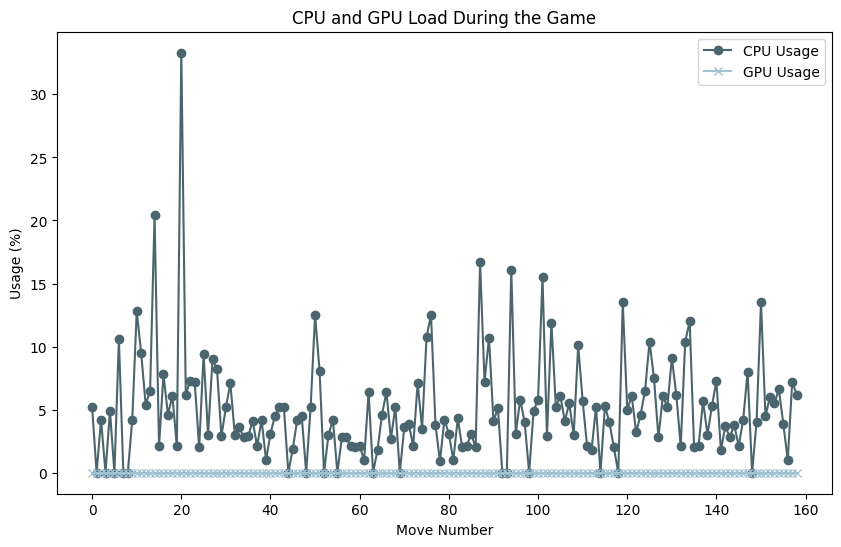

In [50]:
def plot_load(cpu_usage_list, gpu_usage_list):
    plt.figure(figsize=(10, 6))

    plt.plot(cpu_usage_list, label="CPU Usage", color="#4a656d", linestyle='-', marker='o')

    plt.plot(gpu_usage_list, label="GPU Usage", color="#9fc3d1", linestyle='-', marker='x')

    plt.xlabel('Move Number')
    plt.ylabel('Usage (%)')
    plt.title('CPU and GPU Load During the Game')
    plt.legend()
    plt.show()

'''
evaluations_white, evaluations_black, cpu_usage_list, gpu_usage_list, move_times = play_full_game()
'''

plot_load(cpu_usage_list, gpu_usage_list)

#### Function for time tracking for one stroke

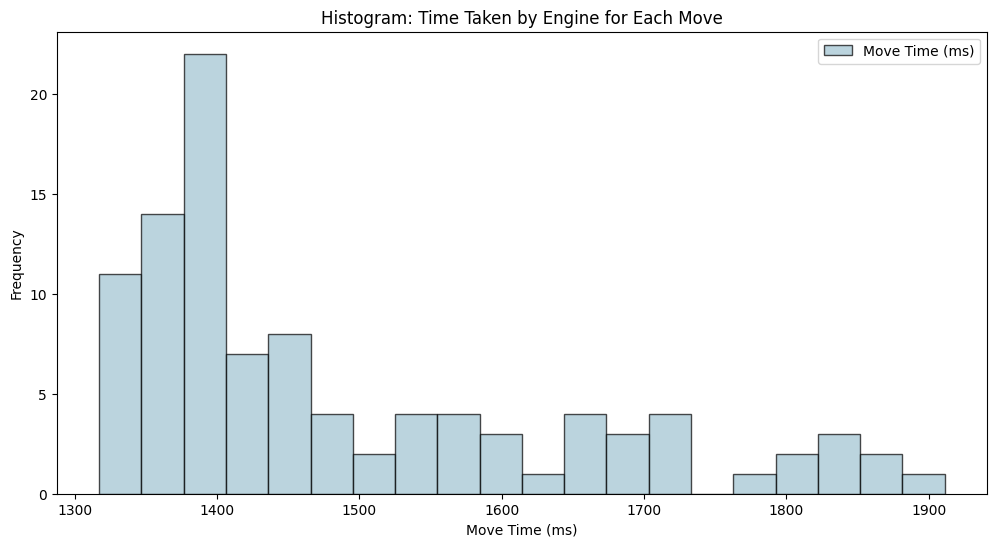

In [51]:
def plot_move_times(move_times):
    plt.figure(figsize=(12, 6))
    plt.hist(move_times, bins=20, alpha=0.7, color='#9fc3d1', edgecolor='black', label="Move Time (ms)")

    plt.xlabel("Move Time (ms)")
    plt.ylabel("Frequency")
    plt.title("Histogram: Time Taken by Engine for Each Move")
    plt.legend()
    plt.show()

plot_move_times(move_times)

#### Position evaluation per move histogram
##### clearly shows how the position changed and which player had the advantage throughout the game. Each bar represents the position score after each move, where one group of bars represents the scores for White players and the other group represents the scores for Black players

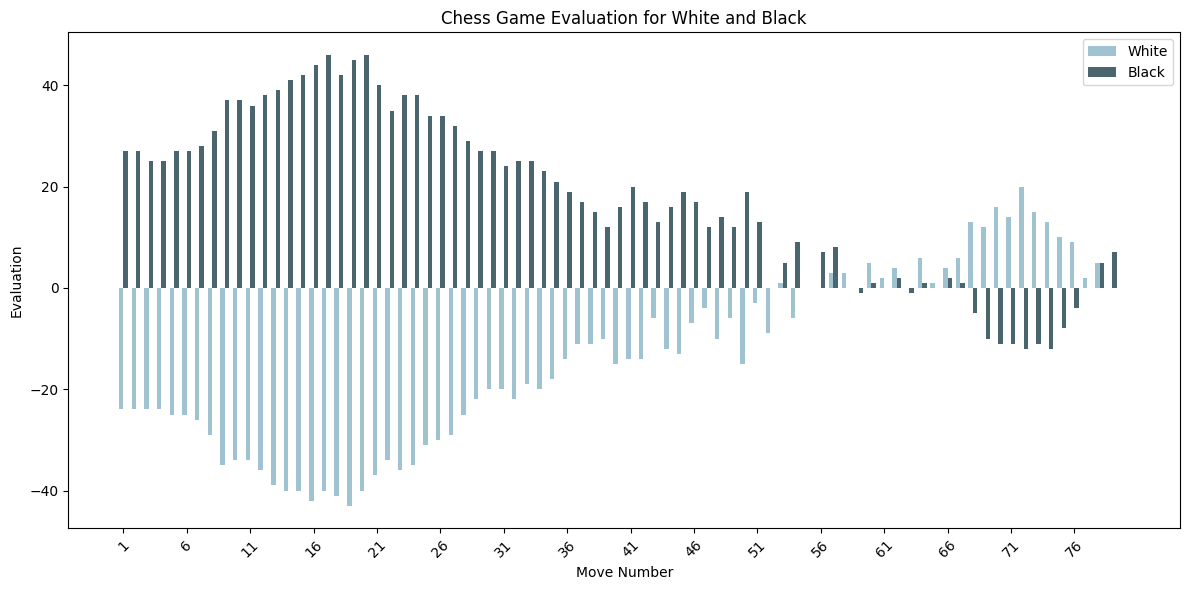

In [52]:
len_white = len(evaluations_white)
len_black = len(evaluations_black)

if len_white > len_black:
    evaluations_black.extend([(0, i) for i in range(len_black, len_white)])
elif len_black > len_white:
    evaluations_white.extend([(0, i) for i in range(len_white, len_black)])

white_evaluations = [score for score, _ in evaluations_white]
black_evaluations = [score for score, _ in evaluations_black]

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(white_evaluations))
width = 0.35

ax.bar(x - width/2, white_evaluations, width, label='White', color='#9fc3d1')
ax.bar(x + width/2, black_evaluations, width, label='Black', color='#4a656d')

ax.set_xlabel('Move Number')
ax.set_ylabel('Evaluation')
ax.set_title('Chess Game Evaluation for White and Black')

tick_interval = 5
ax.set_xticks(x[::tick_interval])
ax.set_xticklabels([f'{i+1}' for i in x[::tick_interval]])
plt.xticks(rotation=45)

ax.legend()

plt.tight_layout()
plt.show()

## STOCKFISH